### State
First, define the State of the graph.

The State schema serves as the input schema for all Nodes and Edges in the graph.

Let's use the TypedDict class from python's typing module as our schema, which provides type hints for the keys.

In [2]:
from typing_extensions import TypedDict


class State(TypedDict):
    graph_state: str

#### Nodes
Nodes are just python functions.

The first positional argument is the state, as defined above.

Because the state is a TypedDict with schema as defined above, each node can access the key, graph_state, with state['graph_state'].

Each node returns a new value of the state key graph_state.

By default, the new value returned by each node will override the prior state value.

In [3]:
def first_node(state):
    print("My First Node is called")
    return {"graph_state": state["graph_state"] + "I am playing"}


def second_node(state):
    print("My Second Node is called")
    return {"graph_state": state["graph_state"] + " Cricket"}


def third_node(state):
    print("My Third Node is called")
    return {"graph_state": state["graph_state"] + " Badminton"}

#### Edges
Edges connect the nodes.

Normal Edges are used if you want to always go from, for example, node_1 to node_2.

Conditional Edges are used if you want to optionally route between nodes.

Conditional edges are implemented as functions that return the next node to visit based upon some logic.

In [4]:
import random
from typing import Literal


def decide_play(state) -> Literal["second_node", "third_node"]:
    graph_state = state["graph_state"]

    if random.random() < 0.5:
        return "second_node"

    return "third_node"

## Graph 


#### Graph Construction
Now, we build the graph from our components defined above.

The StateGraph class is the graph class that we can use.

First, we initialize a StateGraph with the State class we defined above.

Then, we add our nodes and edges.

We use the START Node, a special node that sends user input to the graph, to indicate where to start our graph.

The END Node is a special node that represents a terminal node.

Finally, we compile our graph to perform a few basic checks on the graph structure.

We can visualize the graph as a Mermaid diagram.

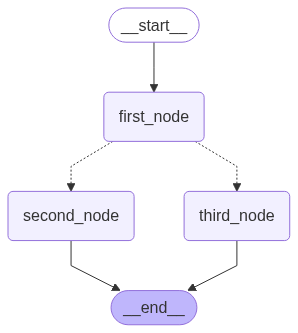

In [6]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

## Build Graph
builder = StateGraph(State)

builder.add_node("first_node", first_node)
builder.add_node("second_node", second_node)
builder.add_node("third_node", third_node)

## Logic
builder.add_edge(START, "first_node")
builder.add_conditional_edges("first_node", decide_play)
builder.add_edge("second_node", END)
builder.add_edge("third_node", END)

## Add
graph = builder.compile()

## View
display(Image(graph.get_graph().draw_mermaid_png()))

### Graph Invocation
The compiled graph implements the runnable protocol.

This provides a standard way to execute LangChain components.

invoke is one of the standard methods in this interface.

The input is a dictionary {"graph_state": "Hi, this is lance."}, which sets the initial value for our graph state dict.

When invoke is called, the graph starts execution from the START node.

It progresses through the defined nodes (node_1, node_2, node_3) in order.

The conditional edge will traverse from node 1 to node 2 or 3 using a 50/50 decision rule.

Each node function receives the current state and returns a new value, which overrides the graph state.

The execution continues until it reaches the END node.

In [7]:
graph.invoke({"graph_state": "Hi,My name is Krish,"})

My First Node is called
My Third Node is called


{'graph_state': 'Hi,My name is Krish,I am playing Badminton'}

### Basic Chatbot

In [9]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [10]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [11]:
graph_builder = StateGraph(State)

In [13]:
import os
from dotenv import load_dotenv

load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [15]:
from langchain_groq import ChatGroq

llm = ChatGroq(model="gemma2-9b-it")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x112701290>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x11283de50>, model_name='gemma2-9b-it', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [16]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}

In [17]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

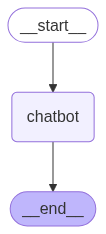

In [18]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [19]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [20]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Let's break down AI agents and agentic AI:

**What is an AI Agent?**

At its core, an AI agent is a system that:

* **Perceives its environment:** It takes in information about the world through sensors (like cameras, microphones, or data feeds).
* **Acts upon its environment:** It can make decisions and take actions to influence its surroundings (e.g., moving a robot arm, sending a message, adjusting settings).
* **Has a goal:** It's designed to achieve a specific objective or set of objectives.

Think of an AI agent like a virtual assistant, but much more versatile.  

**Types of AI Agents:**

* **Simple reflex agents:** React directly to their current perception without remembering past experiences.
* **Model-based reflex agents:** Maintain an internal model of the world and use it to make decisions.
* **Goal-based agents:**  Plan actions to achieve specific goals.
* **Utility-based agents:**  Make decisions to maximize a measure of "utility" or satisfaction.
* **Learning